### Outline

1. Recap of Data
2. Feed forward network with pytorch tensors
3. Using pytorch nn functional,linear sequential and optim
4. Moving things to CUDA

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import torch

In [5]:
torch.manual_seed(10)

In [6]:
# color map
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",['red','yellow','green'])

#### Generate data

In [8]:
data,labels=make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


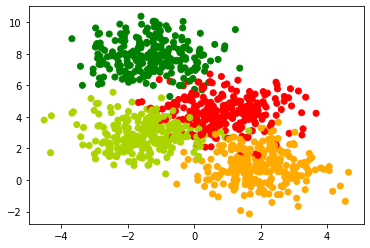

In [10]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)

In [11]:
X_train,X_val,y_train,y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,X_val.shape)

(750, 2) (250, 2)


#### Using torch tensors and autograd

In [12]:
X_train,X_val,y_train,y_val=map(torch.tensor,(X_train,X_val,y_train,y_val))
print(X_train.size(),y_train.size())

torch.Size([750, 2]) torch.Size([750])


In [23]:
def model(x):
    a1=torch.matmul(x,weights1)+bias1 # (N,2) * (2,2) => (N,2)
    h1=a1.sigmoid()
    a2=torch.matmul(h1,weights2)+bias2 # (N,2) * (2,4) => (N,4)
    h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2
    

In [22]:
a=torch.rand(2,4)
print(a)
print(a.exp())
print(a.exp().sum(-1))
print(a.exp().sum(-1).unsqueeze(-1))
print(a.exp()/a.exp().sum(-1).unsqueeze(-1))

tensor([[0.6178, 0.3304, 0.5479, 0.4440],
        [0.7041, 0.5573, 0.6959, 0.9849]])
tensor([[1.8548, 1.3915, 1.7297, 1.5589],
        [2.0220, 1.7459, 2.0054, 2.6776]])
tensor([6.5349, 8.4509])
tensor([[6.5349],
        [8.4509]])
tensor([[0.2838, 0.2129, 0.2647, 0.2385],
        [0.2393, 0.2066, 0.2373, 0.3168]])


In [29]:
print(a.exp())
print(a.exp().sum(0))
print(a.exp().sum(-1)) # 0 is the inner most dimension and it increases outwards
#if you give -1 it will be most outward dimension

tensor([[1.8548, 1.3915, 1.7297, 1.5589],
        [2.0220, 1.7459, 2.0054, 2.6776]])
tensor([3.8768, 3.1373, 3.7351, 4.2365])
tensor([6.5349, 8.4509])


#### intution for calculation of cross entropy

In [32]:
y_hat=torch.tensor([[0.1,0.2,0.3,0.4],[0.8,0.1,0.05,0.05]])
y=[2,0]
print(y_hat[range(y_hat.shape[0]),y]) # this prints for every row value of y_hat the index of y
print(-y_hat[range(y_hat.shape[0]),y].log()) # take the log of this to get loss values
print(-y_hat[range(y_hat.shape[0]),y].log().mean()) # Accumulate this and take the mean.



tensor([0.3000, 0.8000])
tensor([1.2040, 0.2231])
tensor(0.7136)


In [40]:
def loss_fn(yhat,y):
    return -yhat[range(yhat.shape[0]),y].log().mean()    

In [41]:
y_hat=torch.tensor([[0.1,0.2,0.3,0.4],[0.8,0.1,0.05,0.05]])
y=torch.tensor([2,0])
print(torch.argmax(y_hat,dim=1))
print((torch.argmax(y_hat,dim=1)==y).float().mean())


tensor([3, 0])
tensor(0.5000)


In [111]:
def accuracy(yhat,y):
    pred=torch.argmax(yhat,dim=1)
    return (pred==y).float().mean()

loss before training :  1.4824687242507935
loss after training :  0.19437552988529205


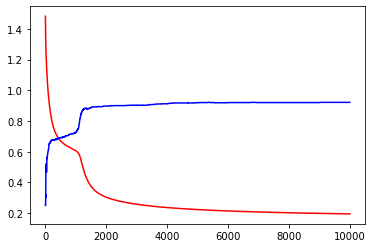

In [142]:
weights1=torch.randn(2,2)/math.sqrt(2)
weights1.requires_grad_()
bias1=torch.zeros(2,requires_grad=True)
weights2=torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2=torch.zeros(4,requires_grad=True)
learning_rate=0.2
epochs=10000

X_train=X_train.float()
y_train=y_train.long()
loss_arr=[]
acc_arr=[]

for i in range(epochs):
    y_hat=model(X_train)
    loss=loss_fn(y_hat,y_train)
    loss_arr.append(loss.item())
    acc=accuracy(y_hat,y_train)
    acc_arr.append(acc.item())
    loss.backward()
    with torch.no_grad():
        weights1-=learning_rate*weights1.grad
        bias1-=learning_rate*bias1.grad
        weights2-=learning_rate*weights2.grad
        bias2-=learning_rate*bias2.grad
        weights1.grad.zero_()
        weights2.grad.zero_()
        bias1.grad.zero_()
        bias2.grad.zero_()
    
plt.plot(loss_arr,'r-')
plt.plot(acc_arr,'b-')
print("loss before training : ",loss_arr[0])
print("loss after training : ",loss_arr[-1])

#### Using nn.functional and nn.parameter

In [139]:
import torch.nn as nn
import torch.nn.functional as F

class firstNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights1=nn.Parameter(torch.randn(2,2)/math.sqrt(2))
        self.bias1=nn.Parameter(torch.zeros(2))
        self.weights2=nn.Parameter(torch.randn(2,4)/math.sqrt(4))
        self.bias2=nn.Parameter(torch.zeros(4),requires_grad=True)
    
    def forward(self,x):
        a1=torch.matmul(x,self.weights1)+self.bias1
        h1=a1.sigmoid()
        a2=torch.matmul(h1,self.weights2)+self.bias2
        h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [140]:
list(firstNetwork().parameters())

[Parameter containing:
 tensor([[ 1.4549, -0.0250],
         [ 0.0443, -0.5419]], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.5496,  1.3783,  0.0876, -0.4658],
         [-0.7527, -0.3305,  0.6616,  0.0186]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True)]

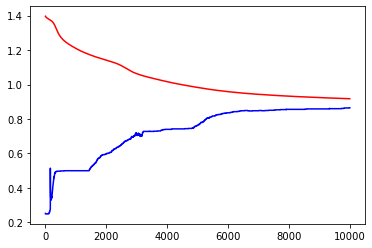

loss before training :  1.3962644338607788
loss after training :  0.9176459908485413


In [141]:
def fit(epochs=10000,learning_rate=0.2):
    loss_arr=[]
    accuracy_arr=[]
    
    for i in range(epochs):
        yhat=fn(X_train)
        loss=F.cross_entropy(yhat,y_train)
        loss_arr.append(loss.item())
        acc=accuracy(yhat,y_train)
        accuracy_arr.append(acc.item())
        loss.backward()
        
        with torch.no_grad():
            for p in fn.parameters():
                p-=learning_rate*p.grad
            fn.zero_grad()
    plt.plot(loss_arr,'r-')
    plt.plot(accuracy_arr,'b-')  
    plt.show()
    print("loss before training : ",loss_arr[0])
    print("loss after training : ",loss_arr[-1])

fn=firstNetwork()
fit()        

#### Using nn.linear and optim

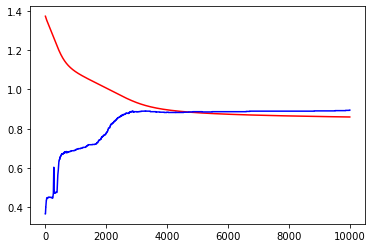

loss before training :  1.3721067905426025
loss after training :  0.859693169593811


In [143]:
class firstNetworkV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1=nn.Linear(2,2)
        self.lin2=nn.Linear(2,4)
    def forward(self,x):
        a1=self.lin1(x)
        h1=a1.sigmoid()
        a2=self.lin2(h1)
        h2=a2.exp()/(a2.exp().sum(-1).unsqueeze(-1))
        return h2
    
fn=firstNetworkV1()
fit()

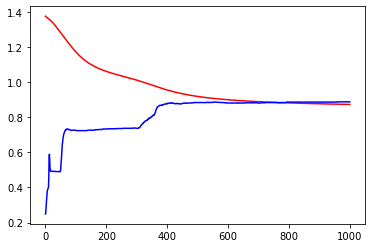

loss before training :  1.3759644031524658
loss after training :  0.8733224272727966


In [150]:
from torch import optim
def fit_v1(epochs=1000,learning_rate=1):
    optimizer=optim.SGD(fn.parameters(),lr=learning_rate)
    loss_arr=[]
    acc_arr=[]
    for i in range(epochs):
        yhat=fn(X_train)
        loss=F.cross_entropy(yhat,y_train)
        loss_arr.append(loss.item())
        acc=accuracy(yhat,y_train)
        acc_arr.append(acc)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    plt.plot(loss_arr,'r-')
    plt.plot(acc_arr,'b-')
    plt.show()
    print("loss before training : ",loss_arr[0])
    print("loss after training : ",loss_arr[-1])

fn=firstNetworkV1()
 
fit_v1()        
        

#### Organized Code

In [162]:
class firstNetwork_V2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net =nn.Sequential(
        nn.Linear(2,2),
        nn.Sigmoid(),
        nn.Linear(2,4),
        nn.Softmax())
    def forward(self,x):
        return self.net(x)
    
def fit_V2(x,y,model,lossfn,opt,epochs=10000):
    for i in range(epochs):
        loss=lossfn(model(x),y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

fn=firstNetwork_V2()
lossfn=F.cross_entropy
opt=optim.SGD(fn.parameters(),lr=0.2)
fit_V2(X_train,y_train,fn,lossfn,opt)

0.8568404316902161

#### How to run the same code on CUDA ?

In [174]:
class firstNetwork_V3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net =nn.Sequential(
        nn.Linear(2,1024),
        nn.Sigmoid(),
        nn.Linear(1024,4),
        nn.Softmax())
    def forward(self,x):
        return self.net(x)

In [175]:
lossfn=F.cross_entropy
device=torch.device("cuda")
X_train=X_train.to(device)
y_train=y_train.to(device)
fn=firstNetwork_V3().to(device)
opt=optim.SGD(fn.parameters(),lr=0.2)

tic=time.time()
print("loss : ",fit_V2(X_train,y_train,fn,lossfn,opt))
tac=time.time()
print("total time : ",tac-tic)

loss :  0.814929187297821
total time :  5.661359786987305


In [176]:
lossfn=F.cross_entropy
device=torch.device("cpu")
X_train=X_train.to(device)
y_train=y_train.to(device)
fn=firstNetwork_V3().to(device)
opt=optim.SGD(fn.parameters(),lr=0.2)

tic=time.time()
print("loss : ",fit_V2(X_train,y_train,fn,lossfn,opt))
tac=time.time()
print("total time : ",tac-tic)

loss :  0.8149172067642212
total time :  32.09688973426819
